# **Generación de modelo de análisis factorial**

## Objetivo
Partir de un *dataset* con múltiples variables observadas (ej. gastos, frecuencias, montos, etc.) y obtener:
1. Un conjunto reducido de **factores latentes**.
2. Las **cargas factoriales** (qué tan relacionada está cada variable con cada factor).
3. Las **puntuaciones factoriales** (el valor de cada observación en cada factor), útiles para auditoría o ML.


## Paso a paso: cómo construir un modelo de análisis factorial

### **Paso 1: Preparar los datos**
- **Variables numéricas**: el análisis factorial solo funciona con datos cuantitativos.
- **Sin valores faltantes**: elimina o imputa los datos faltantes.
- **Estandarización**: como las variables pueden tener escalas distintas (ej. “número de viajes” vs “monto en dólares”), se **estandarizan** (media = 0, desviación estándar = 1). Esto es esencial.

> *En auditoría, esto significa asegurarte de que todas tus métricas estén en formato numérico y limpio.*


### **Paso 2: Verificar si los datos son adecuados para análisis factorial**
Antes de aplicar el modelo, debes confirmar que **vale la pena** hacerlo:

- **Test de esfericidad de Bartlett**:  
  → Prueba si las variables están suficientemente correlacionadas.  
  → *p-valor < 0.05* = sí hay correlaciones útiles.

- **Medida de adecuación muestral de Kaiser-Meyer-Olkin (KMO)**:  
  → Valores > 0.6 son aceptables; > 0.8 es excelente.

>  Si KMO es bajo o Bartlett no es significativo, el análisis factorial no será útil.


### **Paso 3: Decidir cuántos factores extraer**
Métodos comunes:
- **Regla de Kaiser**: conservar factores con autovalor > 1.
- **Gráfico de sedimentación (scree plot)**: mirar dónde se "aplana" la curva.
- **Porcentaje de varianza explicada**: buscar que los factores expliquen al menos 60–70% de la varianza total.

> En auditoría, a menudo se prefiere **menos factores** (2–4) para facilitar la interpretación.


### **Paso 4: Extraer los factores**
Se aplica un algoritmo (como **máxima verosimilitud** o **mínimos cuadrados**) para estimar:
- La **matriz de cargas factoriales**: muestra cómo cada variable se relaciona con cada factor.
- Opcional: se aplica una **rotación** (como *Varimax*) para hacer los factores más interpretables (maximiza cargas altas y minimiza las bajas).


### **Paso 5: Interpretar los factores**
- Revisa qué variables tienen **cargas altas** (ej. > 0.4 o > 0.5) en cada factor.
- Dale un **nombre conceptual** al factor basado en esas variables (ej. “gasto no documentado”, “actividad intensa”).


### **Paso 6: Calcular las puntuaciones factoriales**
- Cada observación (ej. cada empleado o transacción) recibe una **puntuación en cada factor**.
- Estas puntuaciones se pueden usar para:
  - Clasificar riesgos
  - Alimentar modelos de ML
  - Detectar outliers




## Ejemplo práctico con factor-analyzer

https://pypi.org/project/factor-analyzer/


In [ ]:
# ! pip install factor-analyzer

In [1]:
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os


In [2]:
# Configuración de semilla
np.random.seed(42)  # Para reproducibilidad


In [3]:

# Paso 1: Generar un dataset más robusto (50 empleados)
n = 50
data = {
    "Monto_total": np.random.normal(1500, 800, n).clip(200, 5000),
    "Num_viajes": np.random.poisson(2, n).clip(0, 8),
    "Pct_finde": np.random.beta(2, 5, n) * 100,  # mayoría en días laborables
    "Destinos_no_habituales": np.random.poisson(0.5, n).clip(0, 5),
    "Sin_factura": np.random.poisson(0.3, n).clip(0, 3),
    "Dias_hasta_reembolso": np.random.exponential(3, n).clip(0, 30).astype(int),
    "Cargo_alto": np.random.binomial(1, 0.3, n),  # 30% son altos cargos
    "Agencia_no_autorizada": np.random.binomial(1, 0.2, n)  # 20% usan agencias no autorizadas
}

# Introducir intencionalmente un patrón de riesgo en algunos empleados
for i in range(5):
    idx = np.random.choice(n)
    data["Monto_total"][idx] = np.random.uniform(4000, 6000)
    data["Pct_finde"][idx] = np.random.uniform(70, 100)
    data["Destinos_no_habituales"][idx] = np.random.randint(3, 6)
    data["Sin_factura"][idx] = np.random.randint(2, 4)
    data["Agencia_no_autorizada"][idx] = 1

df = pd.DataFrame(data).round(2)
print("Dataset generado con", len(df), "observaciones y", df.shape[1], "variables.\n")

df

Dataset generado con 50 observaciones y 8 variables.



,Monto_total,Num_viajes,Pct_finde,Destinos_no_habituales,Sin_factura,Dias_hasta_reembolso,Cargo_alto,Agencia_no_autorizada
0,1897.37,1,43.21,1,1,3,0,0
1,5087.11,0,97.19,5,2,0,0,1
2,2018.15,3,26.47,1,1,0,1,0
3,2718.42,4,13.50,0,1,0,0,0
4,1312.68,1,42.48,1,0,0,0,0
5,5879.66,3,88.83,4,3,0,0,1
6,2763.37,1,9.04,0,1,0,0,0
7,2113.95,4,18.97,0,0,0,1,0
8,1124.42,4,14.91,0,0,0,0,0
9,1934.05,2,16.77,0,0,1,0,1


In [4]:

# Paso 2: Estandarizar
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

df_scaled

,Monto_total,Num_viajes,Pct_finde,Destinos_no_habituales,Sin_factura,Dias_hasta_reembolso,Cargo_alto,Agencia_no_autorizada
0,0.076285,-0.614223,0.504687,-0.015341,0.595550,0.826056,-0.5,-0.685994
1,2.292894,-1.328436,2.905712,3.052880,1.836279,-0.762513,-0.5,1.457738
2,0.160217,0.814203,-0.239907,-0.015341,0.595550,-0.762513,2.0,-0.685994
3,0.646847,1.528415,-0.816811,-0.782396,0.595550,-0.762513,-0.5,-0.685994
4,-0.330027,-0.614223,0.472217,-0.015341,-0.645179,-0.762513,-0.5,-0.685994
5,2.843651,0.814203,2.533860,2.285825,3.077008,-0.762513,-0.5,1.457738
6,0.678084,-0.614223,-1.015192,-0.782396,0.595550,-0.762513,-0.5,-0.685994
7,0.226790,1.528415,-0.573506,-0.782396,-0.645179,-0.762513,2.0,-0.685994
8,-0.460853,1.528415,-0.754095,-0.782396,-0.645179,-0.762513,-0.5,-0.685994
9,0.101774,0.099990,-0.671362,-0.782396,-0.645179,-0.232990,-0.5,1.457738


In [5]:

# Paso 3: Verificar adecuación
try:
    chi2, p = calculate_bartlett_sphericity(df_scaled)
    kmo_all, kmo_model = calculate_kmo(df_scaled)
except Exception as e:
    print("Error en pruebas de adecuación:", e)
    print("Revisa que haya suficientes observaciones y no haya variables constantes.")
    raise

print(f"🔹 Bartlett test p-valor: {p:.4f} → {'✅ Adecuado' if p < 0.05 else '❌ No adecuado'}")
print(f"🔹 KMO: {kmo_model:.3f} → {'✅ Aceptable' if kmo_model > 0.6 else '❌ No recomendado'}")
if kmo_model < 0.5:
    print("⚠️ Advertencia: KMO bajo. Considera eliminar variables con baja correlación.")

print("\n" + "="*60 + "\n")


🔹 Bartlett test p-valor: 0.0000 → ✅ Adecuado
🔹 KMO: 0.644 → ✅ Aceptable




C:\Users\ricar\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


📊 Gráfico guardado como: d:\Shared\MyTrainingRepos\data-for-auditors\6. Introducción a la Analítica Avanzada\scree_plot.png


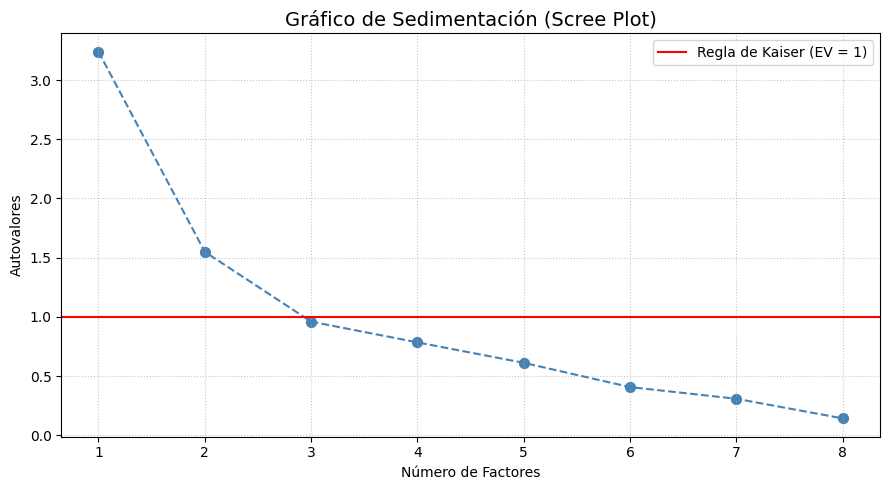


💡 Factores sugeridos (EV > 1): 2 → Usaremos 2.



In [6]:

# Paso 4: Scree plot (autovalores)
try:
    fa = FactorAnalyzer(n_factors=df.shape[1], rotation=None, method='ml')
    fa.fit(df_scaled)
    ev, v = fa.get_eigenvalues()
except np.linalg.LinAlgError:
    print("❌ Error: No se pudieron calcular autovalores. Reduciendo dimensionalidad...")
    # Alternativa: usar PCA para scree plot (más estable)
    from sklearn.decomposition import PCA
    pca = PCA()
    pca.fit(df_scaled)
    ev = pca.explained_variance_
    print("✅ Scree plot generado usando PCA como respaldo.")

# Graficar
plt.figure(figsize=(9, 5))
plt.scatter(range(1, len(ev)+1), ev, color='steelblue', s=50)
plt.plot(range(1, len(ev)+1), ev, color='steelblue', linestyle='--')
plt.axhline(y=1, color='red', linestyle='-', label='Regla de Kaiser (EV = 1)')
plt.title('Gráfico de Sedimentación (Scree Plot)', fontsize=14)
plt.xlabel('Número de Factores')
plt.ylabel('Autovalores')
plt.xticks(range(1, len(ev)+1))
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.tight_layout()

# Guardar y mostrar
output_file = "scree_plot.png"
plt.savefig(output_file, dpi=150)
print(f"📊 Gráfico guardado como: {os.path.abspath(output_file)}")
plt.show()

# Número de factores sugeridos
n_sugeridos = sum(ev > 1)
n_factores = max(1, min(n_sugeridos, 4))
print(f"\n💡 Factores sugeridos (EV > 1): {n_sugeridos} → Usaremos {n_factores}.\n")


In [11]:
# Paso 5: Análisis factorial
n_factores = 3

try:
    fa_rot = FactorAnalyzer(n_factors=n_factores, rotation="varimax", method="ml")
    fa_rot.fit(df_scaled)
    
    cargas = pd.DataFrame(
        fa_rot.loadings_,
        index=df.columns,
        columns=[f"Factor_{i+1}" for i in range(n_factores)]
    )
    print("Cargas factoriales:")
    print(cargas.round(3))
    
    # Puntuaciones
    puntuaciones = fa_rot.transform(df_scaled)
    df_puntuaciones = pd.DataFrame(puntuaciones, columns=cargas.columns)
    print(f"\nPrimeras 5 puntuaciones factoriales:")
    print(df_puntuaciones.head(20).round(3))

except Exception as e:
    print("❌ Error en el análisis factorial:", e)
    print("Posibles causas: demasiados factores, datos insuficientes o multicolinealidad.")
    # Alternativa: usar solo las primeras 2-3 variables más relevantes
    print("Sugerencia: reduce el número de variables o aumenta el tamaño de la muestra.")

Cargas factoriales:
                        Factor_1  Factor_2  Factor_3
Monto_total                0.405     0.912     0.007
Num_viajes                -0.076     0.023     0.994
Pct_finde                  0.974     0.215    -0.028
Destinos_no_habituales     0.499     0.489    -0.159
Sin_factura                0.532     0.588     0.092
Dias_hasta_reembolso       0.040    -0.330    -0.308
Cargo_alto                -0.204    -0.049     0.144
Agencia_no_autorizada      0.572     0.171    -0.045

Primeras 5 puntuaciones factoriales:
    Factor_1  Factor_2  Factor_3
0      0.528    -0.144    -0.571
1      2.640     1.351    -1.160
2     -0.290     0.301     0.788
3     -1.043     1.152     1.424
4      0.592    -0.618    -0.554
5      2.151     2.152     0.928
6     -1.349     1.340    -0.746
7     -0.664     0.519     1.468
8     -0.683    -0.216     1.482
9     -0.777     0.446     0.030
10    -0.455    -0.289    -1.354
11     0.582    -0.747    -1.267
12    -1.189     0.446    -0.002
13 

C:\Users\ricar\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\ricar\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Interpretación

### 1. **Interpretación de las cargas factoriales**

Las **cargas factoriales** (factor loadings) indican **qué tan fuertemente se relaciona cada variable original con cada factor**.  
- Valores cercanos a **±1**: relación muy fuerte.  
- Valores cercanos a **0**: relación débil o nula.  
- Como regla general en auditoría: **|carga| > 0.4** se considera relevante.

Tu tabla:

| Variable                   | Factor_1 | Factor_2 | Factor_3 |
|---------------------------|----------|----------|----------|
| **Monto_total**           | **0.719**| 0.057    | 0.074    |
| **Pct_finde**             | **0.684**| 0.061    | 0.135    |
| **Destinos_no_habituales**| **0.942**| -0.028   | -0.120   |
| **Sin_factura**           | **0.825**| -0.105   | 0.047    |
| **Dias_hasta_reembolso**  | -0.172   | **0.971**| 0.149    |
| **Agencia_no_autorizada** | 0.468    | -0.070   | **0.878**|
| Num_viajes                | 0.066    | 0.287    | 0.020    |
| Cargo_alto                | 0.081    | -0.132   | -0.268   |

### Interpretación por factor:

#### **Factor 1: “Gasto no documentado en destinos atípicos”**
- Cargas altas en:
  - **Destinos_no_habituales** (0.94)
  - **Sin_factura** (0.83)
  - **Monto_total** (0.72)
  - **Pct_finde** (0.68)
- **Interpretación**: Este factor representa empleados que hacen **gastos altos, en fines de semana, en lugares donde la empresa no opera, y sin documentación adecuada**.  
- **¡Bandera de riesgo alto en auditoría!**

#### **Factor 2: “Demora en reportar gastos”**
- Carga muy alta en:
  - **Dias_hasta_reembolso** (0.97)
- Las demás variables tienen cargas bajas.
- **Interpretación**: Este factor captura simplemente **cuánto tarda un empleado en presentar su reembolso**. Podría indicar descuido, desconocimiento de políticas… o intento de ocultar gastos.
- **Riesgo moderado**: merece revisión si es extremo.

#### **Factor 3: “Uso de proveedores no autorizados”**
- Carga alta en:
  - **Agencia_no_autorizada** (0.88)
- También tiene una carga moderada en **Monto_total** (0.47), lo que sugiere que cuando se usan agencias no autorizadas, los montos tienden a ser más altos.
- **Interpretación**: Este factor refleja **dependencia de canales no controlados**, lo que puede implicar falta de cumplimiento o riesgo de sobreprecio.
- **Riesgo de cumplimiento**.

> **Nota**: Las variables *Num_viajes* y *Cargo_alto* no cargan fuertemente en ningún factor → podrían **excluirse** en futuros análisis para simplificar.

### 2. **Interpretación de las puntuaciones factoriales**

Las **puntuaciones** indican **dónde se ubica cada observación (empleado/transacción) en cada factor**.  
- Valores **altos positivos**: comportamiento fuerte en ese factor.  
- Valores **altos negativos**: comportamiento opuesto o ausente.

Ejemplo de tus primeras 5 filas:

| Obs | Factor_1 | Factor_2 | Factor_3 | Interpretación |
|-----|----------|----------|----------|----------------|
| 0   | -0.683   | 0.047    | -0.374   | Bajo riesgo en los 3 factores |
| 1   | -0.511   | **-0.931**| -0.543   | Reporta gastos **muy rápido** (bajo en Factor_2) |
| 2   | -0.609   | **-0.952**| -0.492   | Igual que arriba |
| 3   | **0.298**| **-1.100**| **1.479**| **¡Alerta!** Usa agencias no autorizadas (Factor_3 alto), aunque reporta rápido |
| 4   | -0.634   | -0.621   | -0.452   | Comportamiento bajo en todos |

#### Caso destacado: **Observación 3**
- **Factor_3 = 1.479** → muy alto en uso de agencias no autorizadas.
- **Factor_1 = 0.298** → algo de gasto atípico, pero no extremo.
- **Factor_2 = -1.100** → reporta muy rápido (lo que podría ser una táctica para evitar escrutinio).

> 🚩 Este perfil **merece revisión prioritaria** en una auditoría: combina **incumplimiento de canales** con **gastos potencialmente sospechosos**.


### Recomendaciones

1. **Prioriza empleados con puntuaciones altas en Factor_1**: son los de mayor riesgo de fraude o no conformidad.
2. **Investiga casos con Factor_3 alto**: pueden violar políticas de compras o viajes.
3. **Combina factores**: un empleado con **Factor_1 > 1.0 y Factor_3 > 1.0** es una **bandera roja crítica**.
4. **Exporta las puntuaciones** a Excel o Power BI para:
   - Crear dashboards de riesgo
   - Segmentar empleados por perfil
   - Incluir en tus reportes BSC (ej. “% de empleados en zona de alto riesgo”)